# Лабораторная работа №6

# Импортируем необходимые библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
from sympy import *
from IPython.display import display, Latex

## Выставим стиль для графиков

In [2]:
plt.style.use("cyberpunk")

## 1) Решение систем ОДУ

## Получить траекторию движения спутника вокруг планеты, проведя численное решение задачи двух тел:

$$\cases{x' = z \\ y' = u \\ z' = - \frac{x}{(x^2 + y^2)^{3/2}} \\ u' = - \frac{y}{(x^2 + y^2)^{3/2}}}$$
$$x(0) = 0.5; y(0) = z(0) = 0; u(0) = \sqrt{3}$$

## Решать будем двумя методами:
* ### Явный метод Рунге-Кутты 4 порядка;
* ### Метод Адамса 4 порядка.

## Введем систему и начальные условия

In [3]:
begin = np.array([0.5, 0, 0, np.sqrt(3)])
var('x, y, z, u, t')
f =  Array([z, u, -x/(x**2+y**2)**(1.5), -y/(x**2+y**2)**(1.5)])
func = lambdify((t,[x,y,z,u]), f, 'numpy')

## Явный метод Рунге-Кутты:

In [4]:
def Runge_Kutta4 (Func, initialT, initialСondition, numOfIterations, h):
    solution = [initialСondition]
    t = initialT
    
    for i in range(numOfIterations):
        k1 = Func(t, solution[-1])
        k2 = Func(t + h / 2, solution[-1] + h / 2 * k1)
        k3 = Func(t + h / 2, solution[-1] + h / 2 * k2)
        k4 = Func(t + h, solution[-1] + h * k3)
        t += h
        solution.append(solution[-1] + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4))
        
    return solution

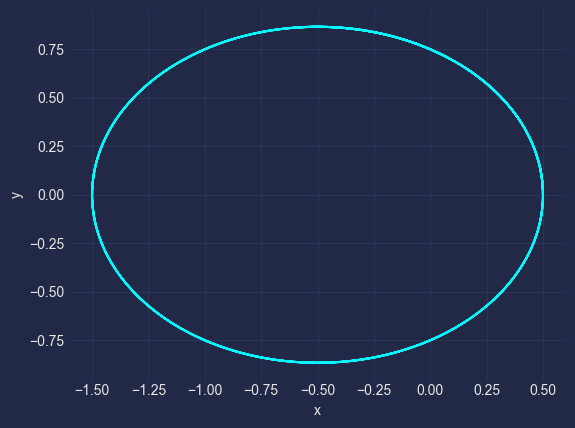

In [5]:
points = Runge_Kutta4(func, 0, begin, 2000, 0.01)
plt.plot([item[0] for item in points], [item[1] for item in points])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Метод Адамса:

## Для начала вычислим 3 точки методом Рунге-Кутты 4 порядка, чтобы вычислить начальные значения для данного метода:

In [6]:
step = 0.01
beginAddams = Runge_Kutta4(func, 0, begin, 3, step)

## Теперь можно реализовать явный метод Адамса 4 порядка:

In [7]:
def Addams4 (Func, initialT, initialСondition, numOfIterations, h):
    solution = initialСondition
    t = initialT
    
    for i in range(numOfIterations):
        solution.append(solution[-1] + h * (55/24*Func(t + 3*h, solution[-1]) - \
                        59/24*Func(t + 2*h, solution[-2]) + 37/24*Func(t + h, solution[-3]) - \
                        3/8*Func(t, solution[-4])))

        t += h
            
    return solution

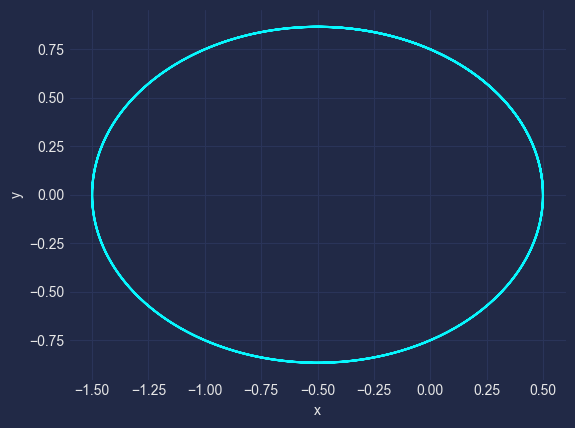

In [8]:
pointsAddams = Addams4(func, 0, beginAddams, 1997, step)
plt.plot([item[0] for item in pointsAddams], [item[1] for item in pointsAddams])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Как и ожидаемо была получена эллиптическая траектория для обоих методов

## 2) Решение жесткой системы ДУ

## Простейшая модель гликолиза описывается уравнениями следующего вида:

$$\cases{y_1' = 1 - y_1 y_2 \\ y_2' = \alpha y_2 \left(y_1 - \frac{1+\beta}{y_2+\beta} \right)}$$
$$\beta = 10; \alpha = 100, 200, 400, 1000$$
$$y_1(0) = 1; y_2(0) = 0.001; T_k = 50$$

In [9]:
beginGlik = np.array([1, 0.001])

## Будем решать данную систему неявным (2, 3) методом Рунге-Кутты:

In [10]:
def DIRC_2_3 (Func, initialT, initialСondition, numOfIterations, h):
    solution = [initialСondition]
    t = initialT
    
    gamma = (3 + np.sqrt(3)) / 6
    c = [gamma, 1 - gamma]
    b = [0.5, 0.5]
    A = [[gamma, 0], [1 - 2 * gamma, gamma]]
    
    for i in range(numOfIterations):
        # simple iteration method
        coeffs = [np.zeros(len(initialСondition)) for l in range(2)]
        
        for j in range(2):
            coeffs = [Func(t + h * c[k], solution[-1] + h * sum([x*y for x,y in zip(coeffs, A[k])])) for k in range(2)]
        
        solution.append(solution[-1] + h * sum([x*y for x,y in zip(coeffs, b)]))
        t += h
    
    return solution

def getGlikFuncFromCoeffs(alpha, beta):
    var('y1, y2, t')
    fGlik =  Array([1 - y1 * y2, alpha * y2 * (y1 - (1 + beta) / (y2 + beta))])
    return lambdify((t,[y1, y2]), fGlik, 'numpy')

def printGraphics(pointsGlik):
    plt.plot([item[0] for item in pointsGlik], [item[1] for item in pointsGlik], linewidth=1)
    plt.xlabel(r'$y_1$')
    plt.ylabel(r'$y_2$')
    plt.show()
    x = np.linspace (0, 50, num=len(pointsGlik))
    plt.plot(x, [item[0] for item in pointsGlik])
    plt.xlabel('t')
    plt.ylabel(r'$y_1$')
    mplcyberpunk.add_glow_effects()
    mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.4)
    plt.show()
    plt.plot(x, [item[1] for item in pointsGlik])
    mplcyberpunk.add_glow_effects()
    mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.4)
    plt.xlabel('t')
    plt.ylabel(r'$y_2$')
    plt.show()

## Далее можно построить решения системы для различных параметров и убедиться в том, что это релаксационные автоколебания (жесткий предельный цикл):

$$\alpha = 100, \beta = 10$$

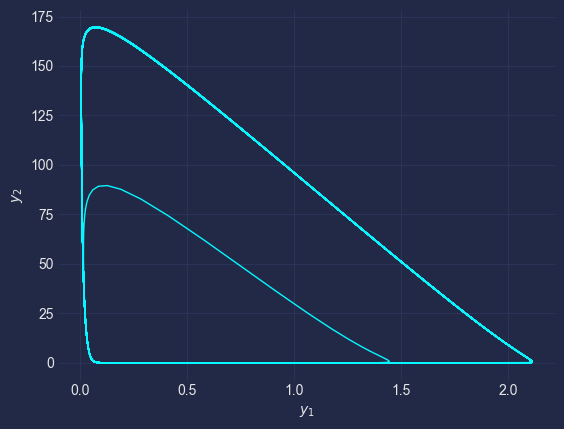

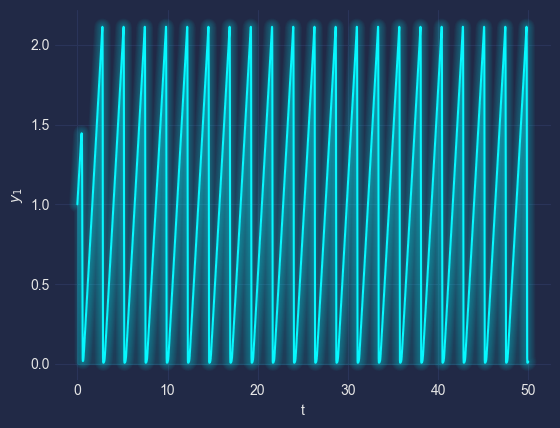

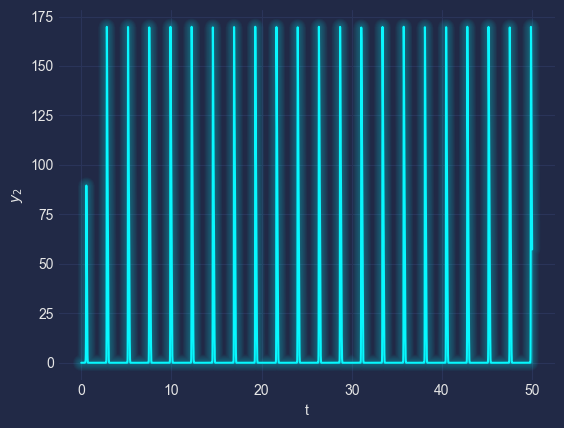

In [11]:
printGraphics(DIRC_2_3(getGlikFuncFromCoeffs(100, 10), 0, beginGlik, 10000, 0.005))

$$\alpha = 200, \beta = 10$$

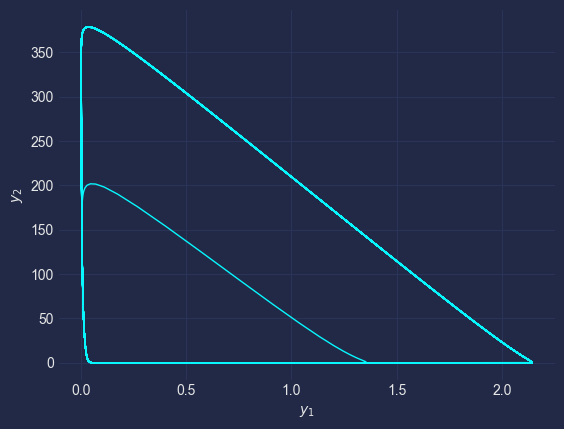

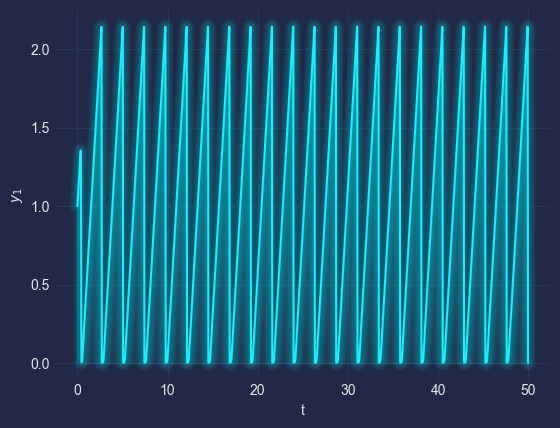

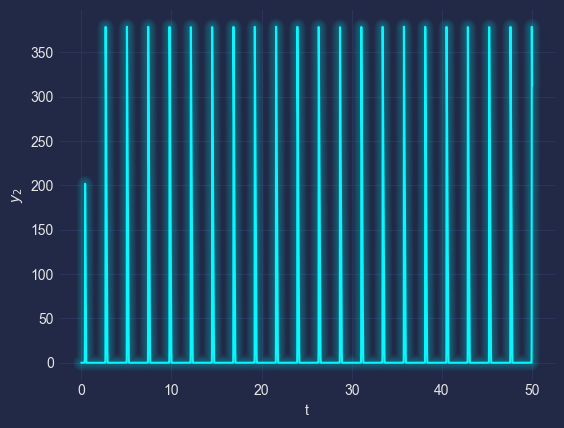

In [12]:
printGraphics(DIRC_2_3(getGlikFuncFromCoeffs(200, 10), 0, beginGlik, 20000, 0.0025))

$$\alpha = 400, \beta = 10$$

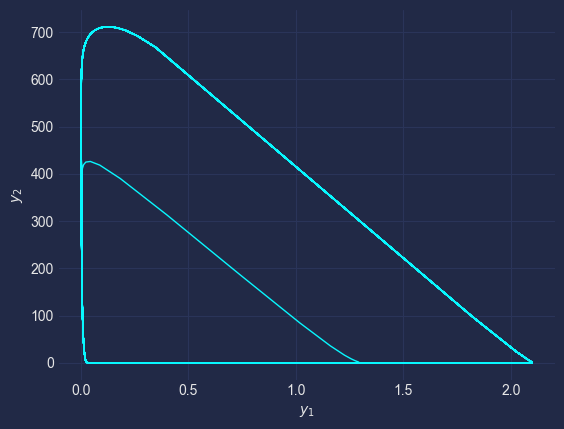

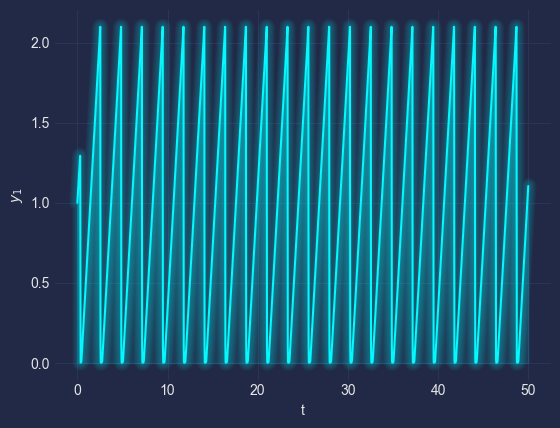

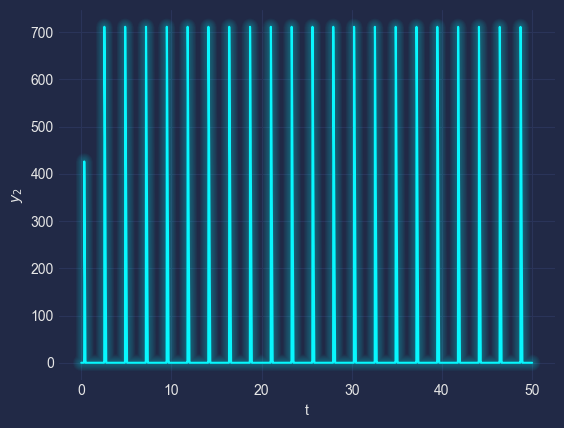

In [13]:
printGraphics(DIRC_2_3(getGlikFuncFromCoeffs(400, 10), 0, beginGlik, 20000, 0.0025))

$$\alpha = 1000, \beta = 10$$

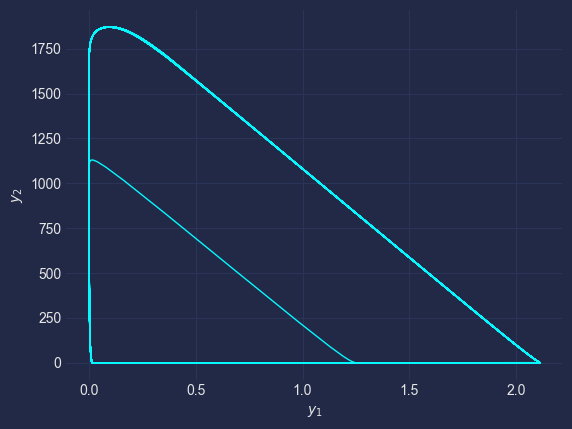

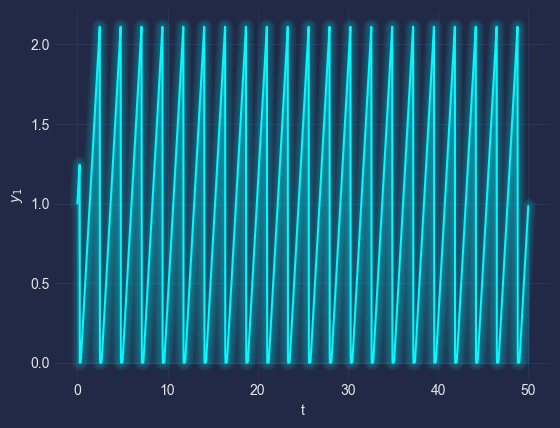

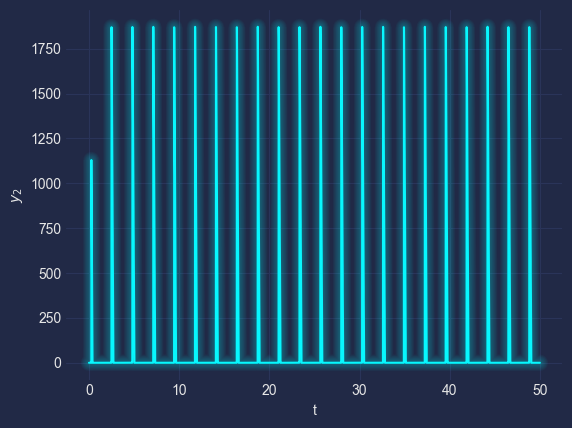

In [14]:
printGraphics(DIRC_2_3(getGlikFuncFromCoeffs(1000, 10), 0, beginGlik, 50000, 0.001))